# ==========================
# HR Analytics – Predict Employee Attrition
# Author: Ayush Rawat
# ==========================

# 1. IMPORT LIBRARIES

In [1]:
import os
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, roc_auc_score, roc_curve,
    confusion_matrix, classification_report
)

import matplotlib.pyplot as plt
import joblib
from packaging import version
import sklearn
RND = 42
np.random.seed(RND)

# 2. Loading data

In [2]:
df=pd.read_csv('HR_Dataset.csv')
print("Loaded dataset:", 'HR_Dataset.csv')
print("Shape:", df.shape)
df.head()

Loaded dataset: HR_Dataset.csv
Shape: (1470, 35)


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


# 3. Preprocessing & Target Encoding

In [3]:
df['Attrition_flag'] = df['Attrition'].map({'Yes': 1, 'No': 0})
print("\nAttrition Distribution:")
print(df['Attrition_flag'].value_counts(normalize=True))

# Drop unnecessary columns
drop_cols = ['EmployeeNumber', 'EmployeeCount', 'Over18', 'StandardHours']
df.drop(columns=[c for c in drop_cols if c in df.columns], inplace=True)

# Separate features and target
X = df.drop(columns=['Attrition', 'Attrition_flag'])
y = df['Attrition_flag']


Attrition Distribution:
Attrition_flag
0    0.838776
1    0.161224
Name: proportion, dtype: float64


# 4. Train-Test Split

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print(f"\nTrain Shape: {X_train.shape}, Test Shape: {X_test.shape}")



Train Shape: (1176, 30), Test Shape: (294, 30)


# 5. Data Preprocessing Pipeline

In [5]:
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

print("\nNumeric Columns:", len(num_cols))
print("Categorical Columns:", len(cat_cols))

# Handle OneHotEncoder param difference for sklearn version
import sklearn
from packaging import version
ohe_kwargs = {'sparse_output': False} if version.parse(sklearn.__version__) >= version.parse("1.4") else {'sparse': False}

num_transformer = Pipeline(steps=[('scaler', StandardScaler())])
cat_transformer = Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore', **ohe_kwargs))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('cat', cat_transformer, cat_cols)
    ]
)


Numeric Columns: 23
Categorical Columns: 7


# 6. Helper Function for Model Training

In [6]:
def train_and_evaluate_model(name, model):
    """
    Trains model with preprocessing pipeline and prints metrics.
    """
    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', model)])
    pipe.fit(X_train, y_train)

    # Predictions
    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:, 1]

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)
    print(f"\n Model: {name}")
    print(f"Accuracy: {acc:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred, digits=4))

    return {'name': name, 'pipeline': pipe, 'y_pred': y_pred, 'y_proba': y_proba, 'acc': acc, 'roc_auc': roc_auc}

#  7. Train Multiple Models

In [7]:
results = []

# Logistic Regression
lr = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
results.append(train_and_evaluate_model("Logistic Regression", lr))

# Decision Tree
dt = DecisionTreeClassifier(random_state=42)
results.append(train_and_evaluate_model("Decision Tree", dt))

# Random Forest
rf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced', n_jobs=-1)
results.append(train_and_evaluate_model("Random Forest", rf))


 Model: Logistic Regression
Accuracy: 0.7517
ROC-AUC: 0.8032
Confusion Matrix:
 [[191  56]
 [ 17  30]]
Classification Report:
               precision    recall  f1-score   support

           0     0.9183    0.7733    0.8396       247
           1     0.3488    0.6383    0.4511        47

    accuracy                         0.7517       294
   macro avg     0.6336    0.7058    0.6453       294
weighted avg     0.8272    0.7517    0.7775       294


 Model: Decision Tree
Accuracy: 0.7653
ROC-AUC: 0.6105
Confusion Matrix:
 [[207  40]
 [ 29  18]]
Classification Report:
               precision    recall  f1-score   support

           0     0.8771    0.8381    0.8571       247
           1     0.3103    0.3830    0.3429        47

    accuracy                         0.7653       294
   macro avg     0.5937    0.6105    0.6000       294
weighted avg     0.7865    0.7653    0.7749       294


 Model: Random Forest
Accuracy: 0.8469
ROC-AUC: 0.7832
Confusion Matrix:
 [[244   3]
 [ 42   5]

# 8. Compare ROC Curves

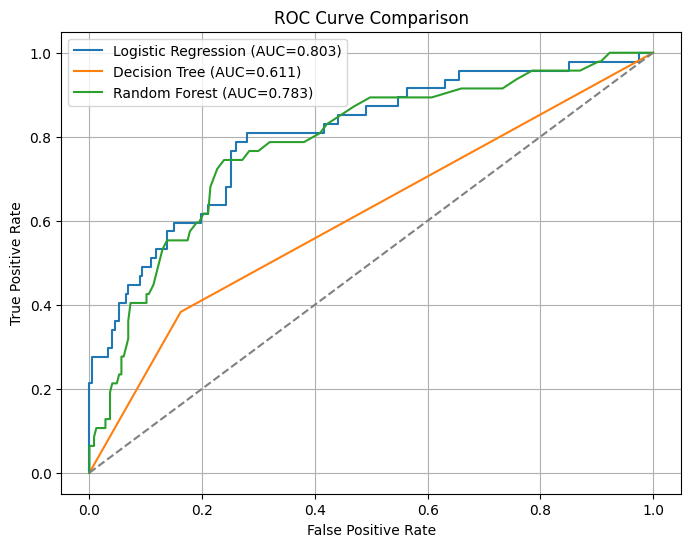

In [8]:
plt.figure(figsize=(8,6))
for r in results:
    fpr, tpr, _ = roc_curve(y_test, r['y_proba'])
    plt.plot(fpr, tpr, label=f"{r['name']} (AUC={r['roc_auc']:.3f})")

plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.grid(True)
plt.show()


# 9. Identify Best Model

In [9]:
best_model = max(results, key=lambda x: x['roc_auc'])
print(f"\n Best Model: {best_model['name']} (ROC-AUC = {best_model['roc_auc']:.4f})")


 Best Model: Logistic Regression (ROC-AUC = 0.8032)


# 10. Output

In [10]:
output_dir = Path("outputs")
output_dir.mkdir(exist_ok=True)

test_out = X_test.copy()
test_out['actual'] = y_test.values
test_out['pred_proba'] = best_model['y_proba']
test_out['pred_label'] = best_model['y_pred']

# Create Risk Level
test_out['Risk_Level'] = np.where(
    test_out['pred_proba'] >= 0.7, 'High',
    np.where(test_out['pred_proba'] >= 0.4, 'Medium', 'Low')
)

# Save to CSV
output_path = output_dir / "attrition_predictions_for_pbi.csv"
test_out.to_csv(output_path, index=False)
print(f"\n Predictions saved to: {output_path.resolve()}")


 Predictions saved to: C:\Users\rawat\Desktop\Internship\Project 1\outputs\attrition_predictions_for_pbi.csv


# Model Performance Summary

In [11]:
import pandas as pd

summary = pd.DataFrame([
    {'Model': r['name'], 'Accuracy': round(r['acc'], 4), 'ROC_AUC': round(r['roc_auc'], 4)}
    for r in results
])

summary = summary.sort_values(by='ROC_AUC', ascending=False).reset_index(drop=True)

print(" Model Performance Summary\n")
print(summary.to_string(index=False))


 Model Performance Summary

              Model  Accuracy  ROC_AUC
Logistic Regression    0.7517   0.8032
      Random Forest    0.8469   0.7832
      Decision Tree    0.7653   0.6105
